# Extract useful information from Apache Access Logs

# Ingest Logs #

In [1]:
import os
import re
import functools

In [2]:
import pandas as pd
import numpy as np
import altair as alt

In [3]:
import re

HOST = r'^(?P<host>.*?)'
SPACE = r'\s'
IDENTITY = r'\S+'
USER = r'\S+'
TIME = r'(?P<time>\[.*?\])'
REQUEST = r'\"(?P<request>.*?)\"'
STATUS = r'(?P<status>\d{3})'
SIZE = r'(?P<size>\S+)'

REGEX = HOST+SPACE+IDENTITY+SPACE+USER+SPACE+TIME+SPACE+REQUEST+SPACE+STATUS+SPACE+SIZE+SPACE

def parse_access_logs(log_line):
    match = re.search(REGEX,log_line)
    return ( (match.group('host'),
            match.group('time'), 
                      match.group('request') , 
                      match.group('status') ,
                      match.group('size')
                     )
                   )
    return {
        "host": match.group('host'),
        "time": match.group('time'),
        "request": match.group('request'),
        "status": match.group('status'),
        "size": match.group('size'),
    }


In [4]:
datafile = r".\testdata\apache_logs\apache.access.log.PROJECT.small.txt"

In [5]:
os.path.exists(datafile)
with open(datafile,"r") as f:
    data = f.readlines()
    parsed = map(parse_access_logs, data)

logs = pd.DataFrame(list(parsed), columns= ["host", "time", "request", "status", "size"])

In [6]:
def create_df(logfile):
    os.path.exists(logfile)
    with open(logfile,"r") as f:
        data = f.readlines()
        parsed = map(parse_access_logs, data)
        return pd.DataFrame(list(parsed), columns= ["host", "time", "request", "status", "size"])

In [7]:
logdir = r".\testdata\apache_logs"
logfiles = map(lambda x: os.path.join(logdir,x), os.listdir(logdir))
dataframes = map(create_df, logfiles)
df = functools.reduce(lambda acc,x: pd.concat([acc,x], ignore_index=True) , dataframes, pd.DataFrame())

df.head()

,host,time,request,status,size
0,in24.inetnebr.com,[01/Aug/1995:00:00:01 -0400],GET /shuttle/missions/sts-68/news/sts-68-mcc-0...,200,1839
1,uplherc.upl.com,[01/Aug/1995:00:00:07 -0400],GET / HTTP/1.0,304,0
2,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/ksclogo-medium.gif HTTP/1.0,304,0
3,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/MOSAIC-logosmall.gif HTTP/1.0,304,0
4,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/USA-logosmall.gif HTTP/1.0,304,0


In [8]:
len(df)

1043675

In [9]:
#logs = df.loc[:4000]
logs = df

# Explore Data #

In [10]:
logs.head()

,host,time,request,status,size
0,in24.inetnebr.com,[01/Aug/1995:00:00:01 -0400],GET /shuttle/missions/sts-68/news/sts-68-mcc-0...,200,1839
1,uplherc.upl.com,[01/Aug/1995:00:00:07 -0400],GET / HTTP/1.0,304,0
2,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/ksclogo-medium.gif HTTP/1.0,304,0
3,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/MOSAIC-logosmall.gif HTTP/1.0,304,0
4,uplherc.upl.com,[01/Aug/1995:00:00:08 -0400],GET /images/USA-logosmall.gif HTTP/1.0,304,0


In [11]:
logs.describe()

,host,time,request,status,size
count,1043675,1043675,1043675,1043675,1043675
unique,54507,658333,13044,7,5384
top,edams.ksc.nasa.gov,[01/Aug/1995:08:18:28 -0400],GET /images/NASA-logosmall.gif HTTP/1.0,200,0
freq,4034,17,59387,941295,83898


In [12]:
logs.dtypes

host       object
time       object
request    object
status     object
size       object
dtype: object

In [13]:
## filtering
_ = logs[logs["status"] == "200"]
_.head()

,host,time,request,status,size
0,in24.inetnebr.com,[01/Aug/1995:00:00:01 -0400],GET /shuttle/missions/sts-68/news/sts-68-mcc-0...,200,1839
5,ix-esc-ca2-07.ix.netcom.com,[01/Aug/1995:00:00:09 -0400],GET /images/launch-logo.gif HTTP/1.0,200,1713
7,slppp6.intermind.net,[01/Aug/1995:00:00:10 -0400],GET /history/skylab/skylab.html HTTP/1.0,200,1687
8,piweba4y.prodigy.com,[01/Aug/1995:00:00:10 -0400],GET /images/launchmedium.gif HTTP/1.0,200,11853
9,slppp6.intermind.net,[01/Aug/1995:00:00:11 -0400],GET /history/skylab/skylab-small.gif HTTP/1.0,200,9202


In [14]:
_ = logs.groupby(["status"]).groups

### Grouping ###

In [15]:
for name,group in logs.groupby(["status"]):
   print(name)

200
302
304
403
404
500
501


In [16]:
logs.groupby(["status"]).get_group("302").head()

,host,time,request,status,size
47,www-c3.proxy.aol.com,[01/Aug/1995:00:00:57 -0400],"GET /cgi-bin/imagemap/countdown70?285,291 HTTP...",302,85
107,205.163.36.61,[01/Aug/1995:00:02:10 -0400],"GET /cgi-bin/imagemap/countdown70?342,281 HTTP...",302,98
122,rpgopher.aist.go.jp,[01/Aug/1995:00:02:45 -0400],"GET /cgi-bin/imagemap/countdown70?181,275 HTTP...",302,110
158,gw1.att.com,[01/Aug/1995:00:03:53 -0400],GET /shuttle/missions/sts-73/news HTTP/1.0,302,-
165,rpgopher.aist.go.jp,[01/Aug/1995:00:04:05 -0400],"GET /cgi-bin/imagemap/countdown70?51,156 HTTP/1.0",302,111


In [17]:
logs.groupby(["status"]).count()

,host,time,request,size
status,,,,
200,941295,941295,941295,941295
302,16253,16253,16253,16253
304,79864,79864,79864,79864
403,58,58,58,58
404,6186,6186,6186,6186
500,2,2,2,2
501,17,17,17,17


### Transformations ###

In [18]:
def convert_to_int(x):
    try:
        return int(x)
    except:
        return -1

logs["size"] = logs["size"].apply(convert_to_int)

In [19]:
def convert_to_datetime(s):
    import dateutil.parser
    s = s[1: len(s)-1]
    return dateutil.parser.parse(s[:11] + " " + s[12:])
    
logs["time"] = logs["time"].apply(convert_to_datetime)

In [20]:
def day_of_week(d):
    import datetime
    days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"] 
    weekday = d.weekday()
    return days[weekday]

logs["day"] = logs["time"].apply(day_of_week)

In [21]:
logs.head()

,host,time,request,status,size,day
0,in24.inetnebr.com,1995-08-01 00:00:01-04:00,GET /shuttle/missions/sts-68/news/sts-68-mcc-0...,200,1839,Tuesday
1,uplherc.upl.com,1995-08-01 00:00:07-04:00,GET / HTTP/1.0,304,0,Tuesday
2,uplherc.upl.com,1995-08-01 00:00:08-04:00,GET /images/ksclogo-medium.gif HTTP/1.0,304,0,Tuesday
3,uplherc.upl.com,1995-08-01 00:00:08-04:00,GET /images/MOSAIC-logosmall.gif HTTP/1.0,304,0,Tuesday
4,uplherc.upl.com,1995-08-01 00:00:08-04:00,GET /images/USA-logosmall.gif HTTP/1.0,304,0,Tuesday


In [22]:
logs.dtypes

host                                       object
time       datetime64[ns, tzoffset(None, -14400)]
request                                    object
status                                     object
size                                        int64
day                                        object
dtype: object

In [23]:
failed_records = logs[logs["size"] == -1]
print(f"Failed records: {len(failed_records)}")
failed_records.head()

Failed records: 8758


,host,time,request,status,size,day
158,gw1.att.com,1995-08-01 00:03:53-04:00,GET /shuttle/missions/sts-73/news HTTP/1.0,302,-1,Tuesday
321,js002.cc.utsunomiya-u.ac.jp,1995-08-01 00:07:33-04:00,GET /shuttle/resources/orbiters/discovery.gif ...,404,-1,Tuesday
658,gw1.att.com,1995-08-01 00:03:53-04:00,GET /shuttle/missions/sts-73/news HTTP/1.0,302,-1,Tuesday
821,js002.cc.utsunomiya-u.ac.jp,1995-08-01 00:07:33-04:00,GET /shuttle/resources/orbiters/discovery.gif ...,404,-1,Tuesday
1279,tia1.eskimo.com,1995-08-01 00:28:41-04:00,GET /pub/winvn/release.txt HTTP/1.0,404,-1,Tuesday


In [24]:
for name,group in logs.groupby(["day"]):
   print(name)

Friday
Monday
Saturday
Sunday
Thursday
Tuesday
Wednesday


# Visualize #

In [25]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

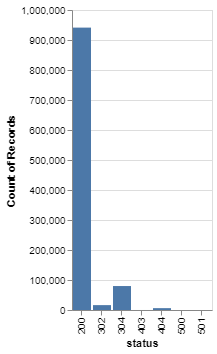

In [26]:
#testlogs = logs.loc[:4000]
testlogs = logs
alt.data_transformers.enable('json')
alt.Chart(testlogs).mark_bar().encode(
    x = 'status',
    y = 'count(*):Q'
)

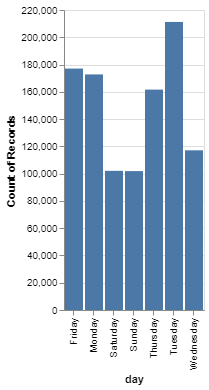

In [30]:
testlogs = logs
alt.data_transformers.enable('json')
alt.Chart(testlogs).mark_bar().encode(
    x = 'day',
    y = 'count(*):Q'
)

# Other Examples #

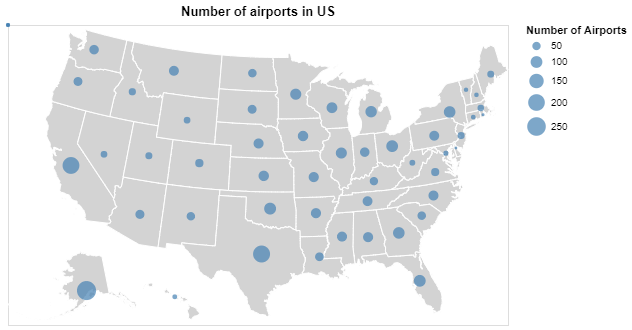

In [27]:
#Ref: https://altair-viz.github.io/gallery/airports_count.html

import altair as alt
from vega_datasets import data

airports = data.airports.url
states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')

# airport positions on background
points = alt.Chart(airports).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='count()',
    groupby=['state']
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('count:Q', title='Number of Airports'),
    color=alt.value('steelblue'),
    tooltip=['state:N','count:Q']
).properties(
    title='Number of airports in US'
)

background + points

## Sandbox ##

In [28]:
def locate_host(ip):
    import requests
    url = f"https://tools.keycdn.com/geo.json?host={ip}"
    resp = requests.get(url)
    assert resp.status_code == 200, f"REST API failed with code {resp.status_code}"
    return resp.json()